In [24]:
import sys, os
print(sys.version)
print(os.environ['HOME'])
java_path = '/home/jovyan/conda'
os.environ['JAVA_HOME'] = java_path
print(os.environ.get('JAVA_HOME'))

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.dbutils import DBUtils
dbutils = DBUtils(spark.sparkContext)
dbutils.fs.ls("/mnt")

3.5.5 | packaged by conda-forge | (default, Jul 23 2018, 23:45:43) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
/home/jovyan
/home/jovyan/conda


[FileInfo(path='dbfs:/mnt/AWStest/', name='AWStest/', size=0),
 FileInfo(path='dbfs:/mnt/WoS/', name='WoS/', size=0),
 FileInfo(path='dbfs:/mnt/test/', name='test/', size=0),
 FileInfo(path='dbfs:/mnt/test2/', name='test2/', size=0),
 FileInfo(path='dbfs:/mnt/test3/', name='test3/', size=0),
 FileInfo(path='dbfs:/mnt/test7/', name='test7/', size=0)]

In [25]:
import pyspark.sql.functions as sql

#ref = spark.read.format("csv").option("header", "false").option("delimiter", "\t").load("/mnt/test/mag/PaperReferences.txt")
#ref.select("_c0", "_c1").toDF("citing", "cited").write.mode('overwrite').bucketBy(64, "cited").saveAsTable("allRef")
ref = spark.read.table("allRef0").dropDuplicates()
ref.describe().filter(sql.col("summary") == "count").show(5)

+-------+---------+---------+
|summary|   citing|    cited|
+-------+---------+---------+
|  count|895891378|895891378|
+-------+---------+---------+



In [26]:
import pandas as pd
from pandas import DataFrame

ego = pd.read_csv('../../packages/issi_data_package/output_files/data/774e7eb6-6ac7-4dd5-9339-531b746cb8ec.csv')
degree1 = pd.read_csv('../../packages/issi_data_package/output_files/data/774e7eb6-6ac7-4dd5-9339-531b746cb8ec_nodes.csv')
edges = pd.read_csv('../../packages/issi_data_package/output_files/data/2ndOrderEdges.csv')
#degree1edge = DataFrame.drop_duplicates(degree1edge)
#display(ego,degree1)
citations = pd.merge(edges, ego, left_on=['To'], right_on=['paper_id'], how='inner')
edges.count()

From                    71946
To                      71946
paper_id                71946
year                    71946
original_title          71946
authors_display_name    71946
journal_display_name    71946
paper_abstract          70508
dtype: int64

In [27]:
from pyspark.sql.functions import broadcast
ego = ego[['paper_id','original_title']]
egoSpark = spark.createDataFrame(ego)
#egoSpark.describe().filter(sql.col("summary") == "count").show(5)

edges = ref.join(broadcast(egoSpark), (egoSpark["paper_id"] == ref["cited"]), "inner").select("cited","citing")
edges.describe().filter(sql.col("summary") == "count").show(20)

+-------+-----+------+
|summary|cited|citing|
+-------+-----+------+
|  count|96137| 96137|
+-------+-----+------+



In [28]:
egos = edges.toDF("focal","connector")
egos2 = egos.join(edges, (egos["connector"] == edges["cited"]), "inner")
#egos2.describe().filter(sql.col("summary") == "count").show(20)
egos0 = edges.toDF("cited2","LE")
egos3 = egos2.join(egos0, (egos2["focal"] == egos0["cited2"]) & (egos2["citing"] == egos0["LE"]), "inner")
egos3.describe().filter(sql.col("summary") == "count").show(20)

+-------+-----+---------+-----+------+------+-----+
|summary|focal|connector|cited|citing|cited2|   LE|
+-------+-----+---------+-----+------+------+-----+
|  count|58134|    58134|58134| 58134| 58134|58134|
+-------+-----+---------+-----+------+------+-----+



In [29]:
ego[ego['paper_id'] == 1966024011]

,paper_id,original_title
880,1966024011,Field-normalized citation impact indicators us...


In [30]:
oneHop = edges.filter(sql.col("cited") == "1966024011").toDF("focal","connector")
twoHops = oneHop.join(edges, (oneHop["connector"] == edges["cited"]), "inner")
oneHop0 = oneHop.toDF("cited2","LE")
ego0 = twoHops.join(oneHop0, (twoHops["focal"] == oneHop0["cited2"]) & (twoHops["citing"] == oneHop0["LE"]), "inner")
ego0.describe().filter(sql.col("summary") == "count").show(20)

+-------+-----+---------+-----+------+------+---+
|summary|focal|connector|cited|citing|cited2| LE|
+-------+-----+---------+-----+------+------+---+
|  count|   61|       61|   61|    61|    61| 61|
+-------+-----+---------+-----+------+------+---+



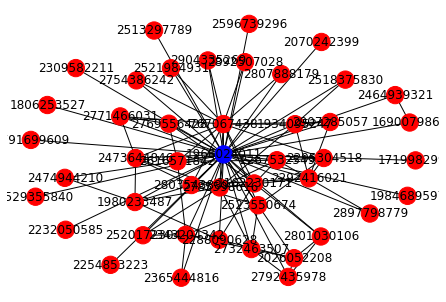

None

In [32]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

subgraph = oneHop.select("focal","connector").distinct().toPandas()
subgraph = subgraph.append(ego0.select("connector","LE").toDF("focal","connector").distinct().toPandas())
G = nx.from_pandas_edgelist(subgraph, "focal", "connector")
pos = nx.spring_layout(G)
color_map = []
for node in G:
    if node == "1966024011":
        color_map.append('blue')
    else: color_map.append('red')    
nx.draw(G, node_color = color_map, with_labels=True, pos=pos)
image = plt.show()
display(image)


In [10]:
plt.close()

In [36]:
len(G)

45

In [37]:
ego0.show(100)

+----------+----------+----------+----------+----------+----------+
|     focal| connector|     cited|    citing|    cited2|        LE|
+----------+----------+----------+----------+----------+----------+
|1966024011|2292416021|2292416021|2907285057|1966024011|2907285057|
|1966024011| 767067438| 767067438|2907285057|1966024011|2907285057|
|1966024011|1934095247|1934095247|2907285057|1966024011|2907285057|
|1966024011|2523550674|2523550674|2732463507|1966024011|2732463507|
|1966024011|2343204342|2343204342|2732463507|1966024011|2732463507|
|1966024011|2026052208|2026052208|2732463507|1966024011|2732463507|
|1966024011| 767067438| 767067438|1934095247|1966024011|1934095247|
|1966024011| 767067438| 767067438|2521984931|1966024011|2521984931|
|1966024011| 767067438| 767067438|2754386242|1966024011|2754386242|
|1966024011|1162230171|1162230171|2267532549|1966024011|2267532549|
|1966024011|1934095247|1934095247|2292416021|1966024011|2292416021|
|1966024011|2267532549|2267532549|2292416021|196